In [1]:
from pathlib import Path
from pylab import cm
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

from layout_gnn.dataset.dataset import RICOSemanticAnnotationsDataset
from layout_gnn.dataset.transformations import *
from layout_gnn.utils import *
from layout_gnn.similarity_metrics import compute_edit_distance, compute_iou

ROOT_PATH = Path.cwd()
DATA_PATH = ROOT_PATH / '../data'
DATA_PATH.mkdir(parents=True, exist_ok=True)

NUM_LABELS = 25
COLORS = cm.get_cmap('nipy_spectral', NUM_LABELS)

In [2]:
rico_dataset = RICOSemanticAnnotationsDataset(
    root_dir=DATA_PATH,
    transform=transforms.Compose([
        process_data,
        normalize_bboxes,
        add_networkx,
        RescaleImage(500, 500)
    ])
)

In [3]:
datapoint_1, datapoint_2 = rico_dataset[0], rico_dataset[100]

In [4]:
color_label_map = {}
for node, data in list(datapoint_1['graph'].nodes(data=True)) + list(datapoint_2['graph'].nodes(data=True)):
    if data['label'] not in color_label_map:
        color_label_map[data['label']] = COLORS(len(color_label_map))

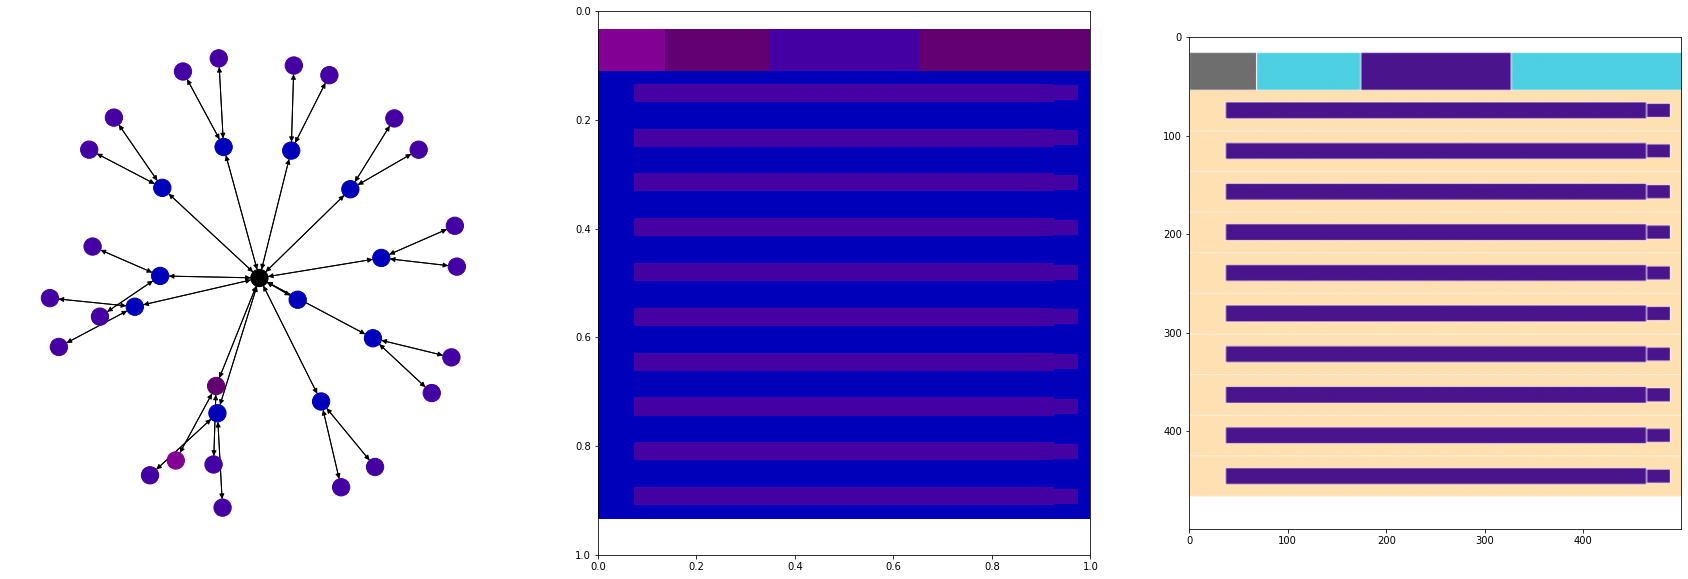

In [5]:
color_node_map = [color_label_map[data['label']] for _, data in list(datapoint_1['graph'].nodes(data=True))]
fig = plot_datapoint(datapoint_1, color_label_map, color_node_map)

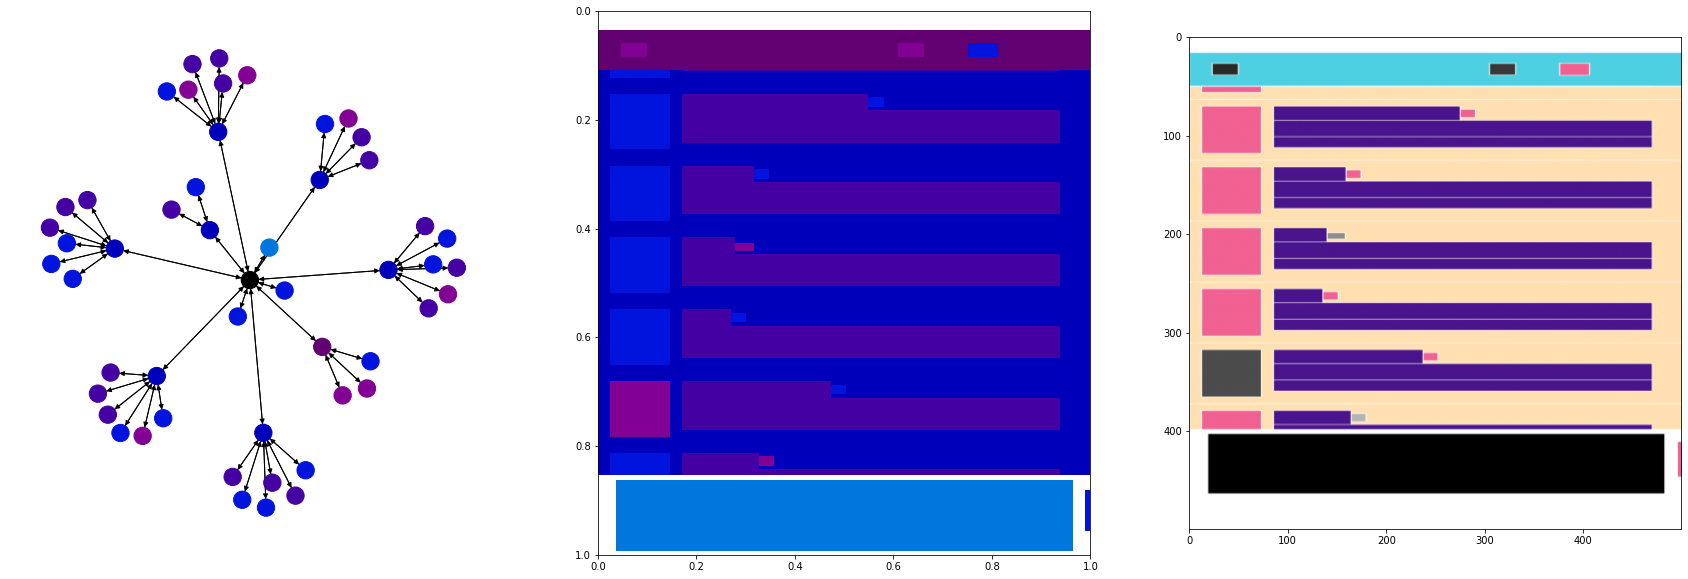

In [6]:
color_node_map = [color_label_map[data['label']] for _, data in list(datapoint_2['graph'].nodes(data=True))]
fig = plot_datapoint(datapoint_2, color_label_map, color_node_map)

## Compute ED between both trees

In [7]:
compute_edit_distance(datapoint_1['graph'].to_undirected(), datapoint_2['graph'].to_undirected())

{'edit_distance': 23.0, 'normalized_edit_distance': 0.26744186046511625}

In [8]:
node_labels = sorted(list(set(node['label'] for _, node in datapoint_1['graph'].nodes(data=True)) | set(node['label'] for _, node in datapoint_2['graph'].nodes(data=True))))
node_labels = {label: idx for idx, label in enumerate(node_labels)}
image_shape = (256, 256)

In [9]:
compute_iou(datapoint_1, datapoint_2)

0.739057613698919